# Trading strategy exploration and backtesting project with Python 3 

##  Load data 

In [1]:
import sys
import numpy as np
import pandas as pd

!{sys.executable} -m pip install --user matplotlib
import matplotlib.pyplot as plt

!{sys.executable} -m pip install --user seaborn
import seaborn as sns
#%matplotlib inline

In [2]:
file_path = sys.path[0]
file_path

'/Users/liaobofei/Desktop/trading-strategy-explorer'

In [3]:
PATH_BTCUSDT1h = "/data/BTCUSDT_1h.csv"
PATH_EOSBTC1d = "/data/EOSBTC_1d.csv"

df = pd.read_csv(file_path+PATH_EOSBTC1d,
                     index_col=0, 
                     parse_dates=True,
                     infer_datetime_format=True)

/var/folders/vg/bhspxhys62sg4rcnvltrbvx80000gn/T/ipykernel_25366/2260772897.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(file_path+PATH_EOSBTC1d,
/var/folders/vg/bhspxhys62sg4rcnvltrbvx80000gn/T/ipykernel_25366/2260772897.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path+PATH_EOSBTC1d,



## Exploratory analysis 

In [4]:
df.head()

,date,symbol,open,high,low,close,Volume EOS,Volume BTC,tradecount
unix,,,,,,,,,
1615852800000,2021-03-16 00:00:00,EOS/BTC,0.000069,0.000069,0.000068,0.000069,21863.05,1.501624,317
1615766400000,2021-03-15 00:00:00,EOS/BTC,0.000067,0.000069,0.000065,0.000068,4971908.73,334.720452,27538
1615680000000,2021-03-14 00:00:00,EOS/BTC,0.000070,0.000072,0.000067,0.000067,3455669.25,236.825335,22549
1615593600000,2021-03-13 00:00:00,EOS/BTC,0.000066,0.000072,0.000065,0.000070,4475482.78,304.383043,27466
1615507200000,2021-03-12 00:00:00,EOS/BTC,0.000068,0.000070,0.000066,0.000066,4433265.61,300.109028,23628


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open,103.0,9.596019e-05,2.623371e-05,0.000066,7.750000e-05,8.550000e-05,1.013000e-04,1.584000e-04
high,103.0,9.968738e-05,2.591340e-05,0.000069,8.075000e-05,9.170000e-05,1.072000e-04,1.625000e-04
low,103.0,9.155631e-05,2.578695e-05,0.000065,7.515000e-05,8.090000e-05,9.285000e-05,1.536000e-04
close,103.0,9.509223e-05,2.562799e-05,0.000066,7.735000e-05,8.510000e-05,1.000000e-04,1.572000e-04
Volume EOS,103.0,6.901781e+06,5.068901e+06,21863.050000,3.563374e+06,5.375000e+06,8.873722e+06,2.793215e+07
Volume BTC,103.0,6.245344e+02,4.559379e+02,1.501624,2.950930e+02,4.541848e+02,8.585020e+02,2.368061e+03
tradecount,103.0,3.748917e+04,2.514294e+04,317.000000,2.135100e+04,2.939700e+04,4.850800e+04,1.148760e+05


In [6]:
cols = [i for i in list(df.columns)] # show me all the columns
print(cols)

['date', 'symbol', 'open', 'high', 'low', 'close', 'Volume EOS', 'Volume BTC', 'tradecount']


In [7]:
df.isna().sum() 

date          0
symbol        0
open          0
high          0
low           0
close         0
Volume EOS    0
Volume BTC    0
tradecount    0
dtype: int64


## EOS/BTC Data Preprocessing

In [8]:
def EOSBTC_1d_preprocessing(df):
    df2 = df.copy()
    df2 = df2.drop(['symbol'],axis=1)
    df2 = df2.drop(['tradecount'],axis=1)
    df2 = df2.drop(['Volume EOS'],axis=1)
    df2=df2.rename(columns={'Volume BTC':'Volume'})
    df2=df2.rename(columns={"open": "Open", "close": "Close","high":"High","low":"Low"})
    #We have daily candle, so we can remove, hours, minutes and seconds from our data
    df2['date']=df2['date'].apply(lambda x: str(x).replace('00:00:00',''))
    df2 = df2.set_index('date')
    df2 = df2.sort_values(['date']) # sort by date
    df3 = df2.copy()
    return df3


In [9]:
df_price = EOSBTC_1d_preprocessing(df)

#df_price = df.copy() # OR

df_price.head(5)
df_price.tail(5)

,Open,High,Low,Close,Volume
date,,,,,
2021-03-12,0.000068,0.000070,0.000066,0.000066,300.109028
2021-03-13,0.000066,0.000072,0.000065,0.000070,304.383043
2021-03-14,0.000070,0.000072,0.000067,0.000067,236.825335
2021-03-15,0.000067,0.000069,0.000065,0.000068,334.720452
2021-03-16,0.000069,0.000069,0.000068,0.000069,1.501624


My first value is the last one in time order, so I have to reorder my dataset.


## Plot data

In [10]:
import matplotlib.ticker as ticker
def plot_time_series(df, Y):
    sns.set_theme(style="darkgrid")
    sns.set(rc={"figure.figsize":(25, 20)})
    # build the figure
    fig, ax = plt.subplots()
    sns.lineplot(data=df, x=df.index , y=Y)
    
    # assign locator and formatter for the xaxis ticks.
    tick_spacing=20
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # put the labels at 45deg since they tend to be too long
    fig.autofmt_xdate()
    plt.show()


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


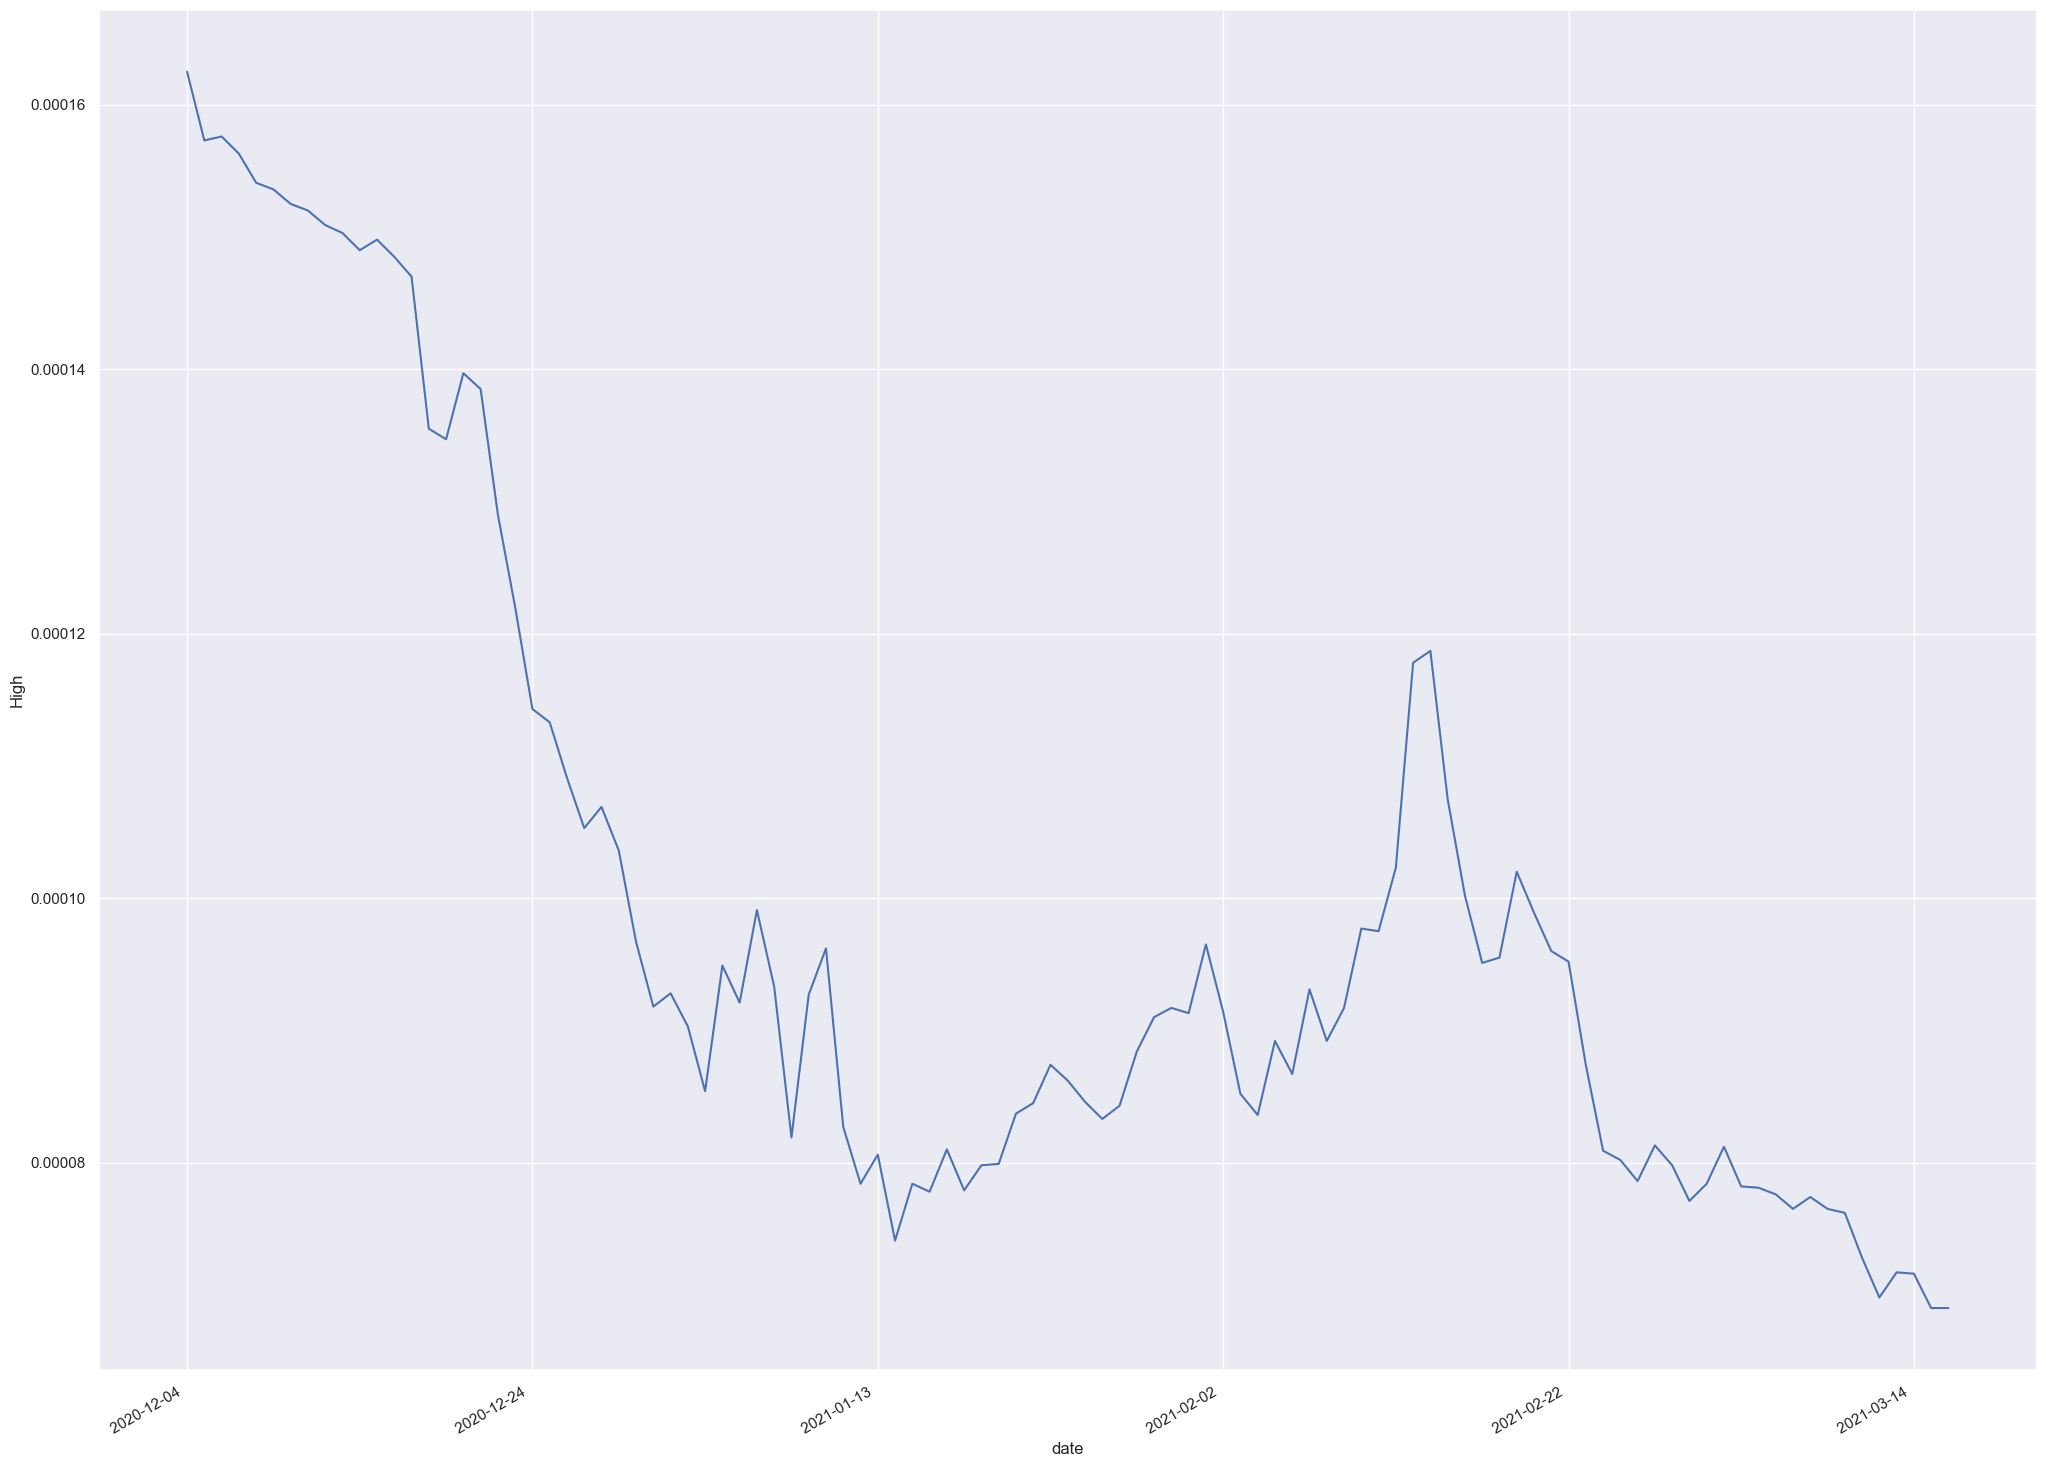

In [11]:
plot_time_series(df_price,'High')

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


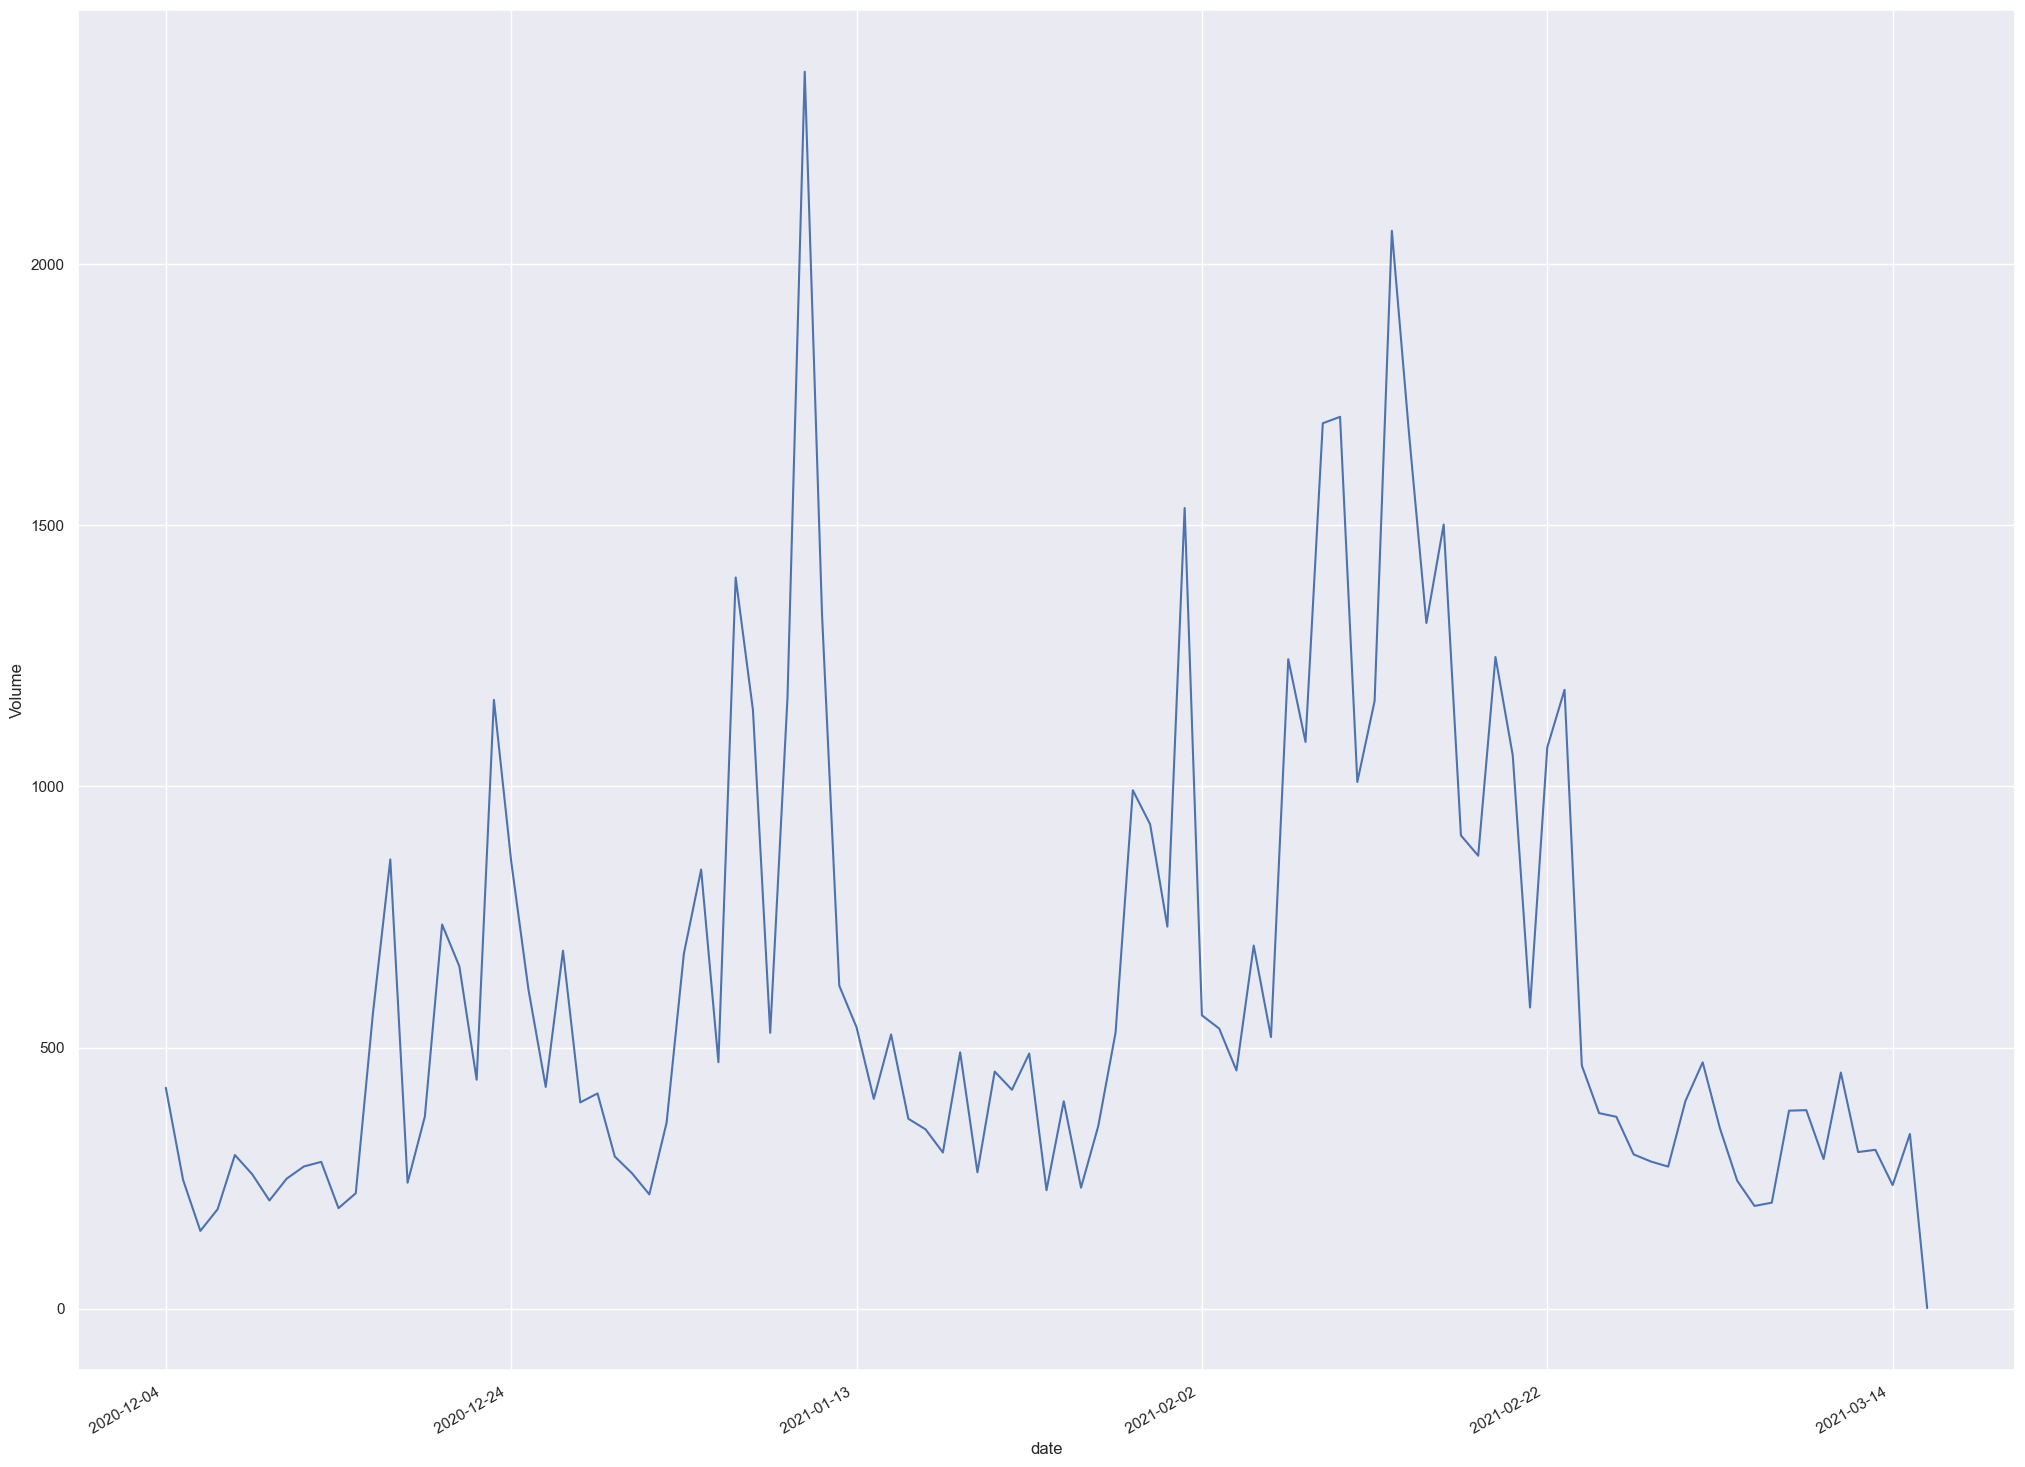

In [12]:
plot_time_series(df_price,'Volume')

## Backtesting


OPEN LONG position  |  2020-12-15   open operation price : 0.0001473
CLOSE LONG position | equity: 10035.0  at  2020-12-17   gain:  35.0 $  close operation price : 0.0001333

OPEN LONG position  |  2020-12-18   open operation price : 0.0001324
CLOSE LONG position | equity: 10045.54  at  2020-12-19   gain:  10.537 $  close operation price : 0.0001282

OPEN LONG position  |  2020-12-22   open operation price : 0.0001218
CLOSE LONG position | equity: 10101.04  at  2020-12-23   gain:  55.502 $  close operation price : 9.97e-05

OPEN LONG position  |  2020-12-24   open operation price : 0.0001124
CLOSE LONG position | equity: 10112.4  at  2020-12-25   gain:  11.364 $  close operation price : 0.0001079

OPEN LONG position  |  2020-12-26   open operation price : 9.86e-05
CLOSE LONG position | equity: 10100.27  at  2020-12-27   gain:  -12.135 $  close operation price : 0.0001034

OPEN LONG position  |  2020-12-29   open operation price : 9.64e-05
CLOSE LONG position | equity: 10115.42  at  20

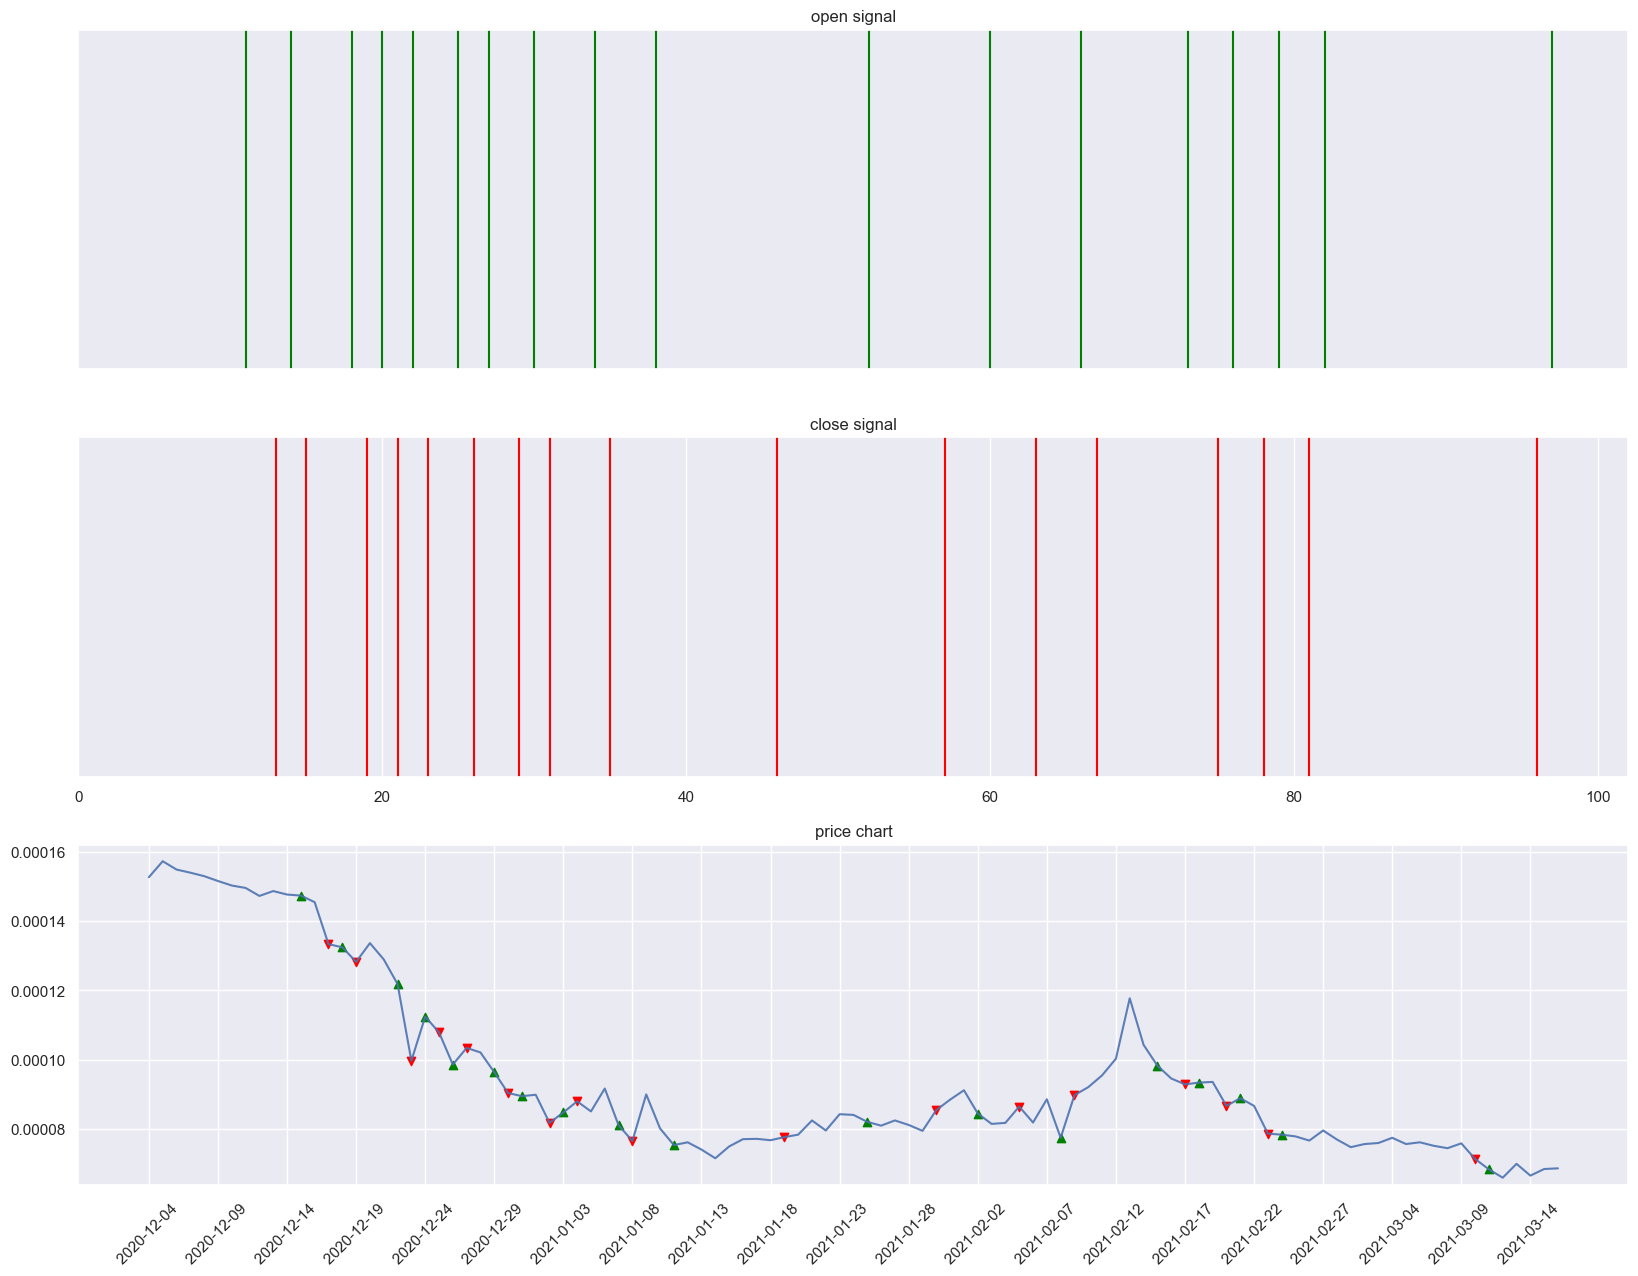

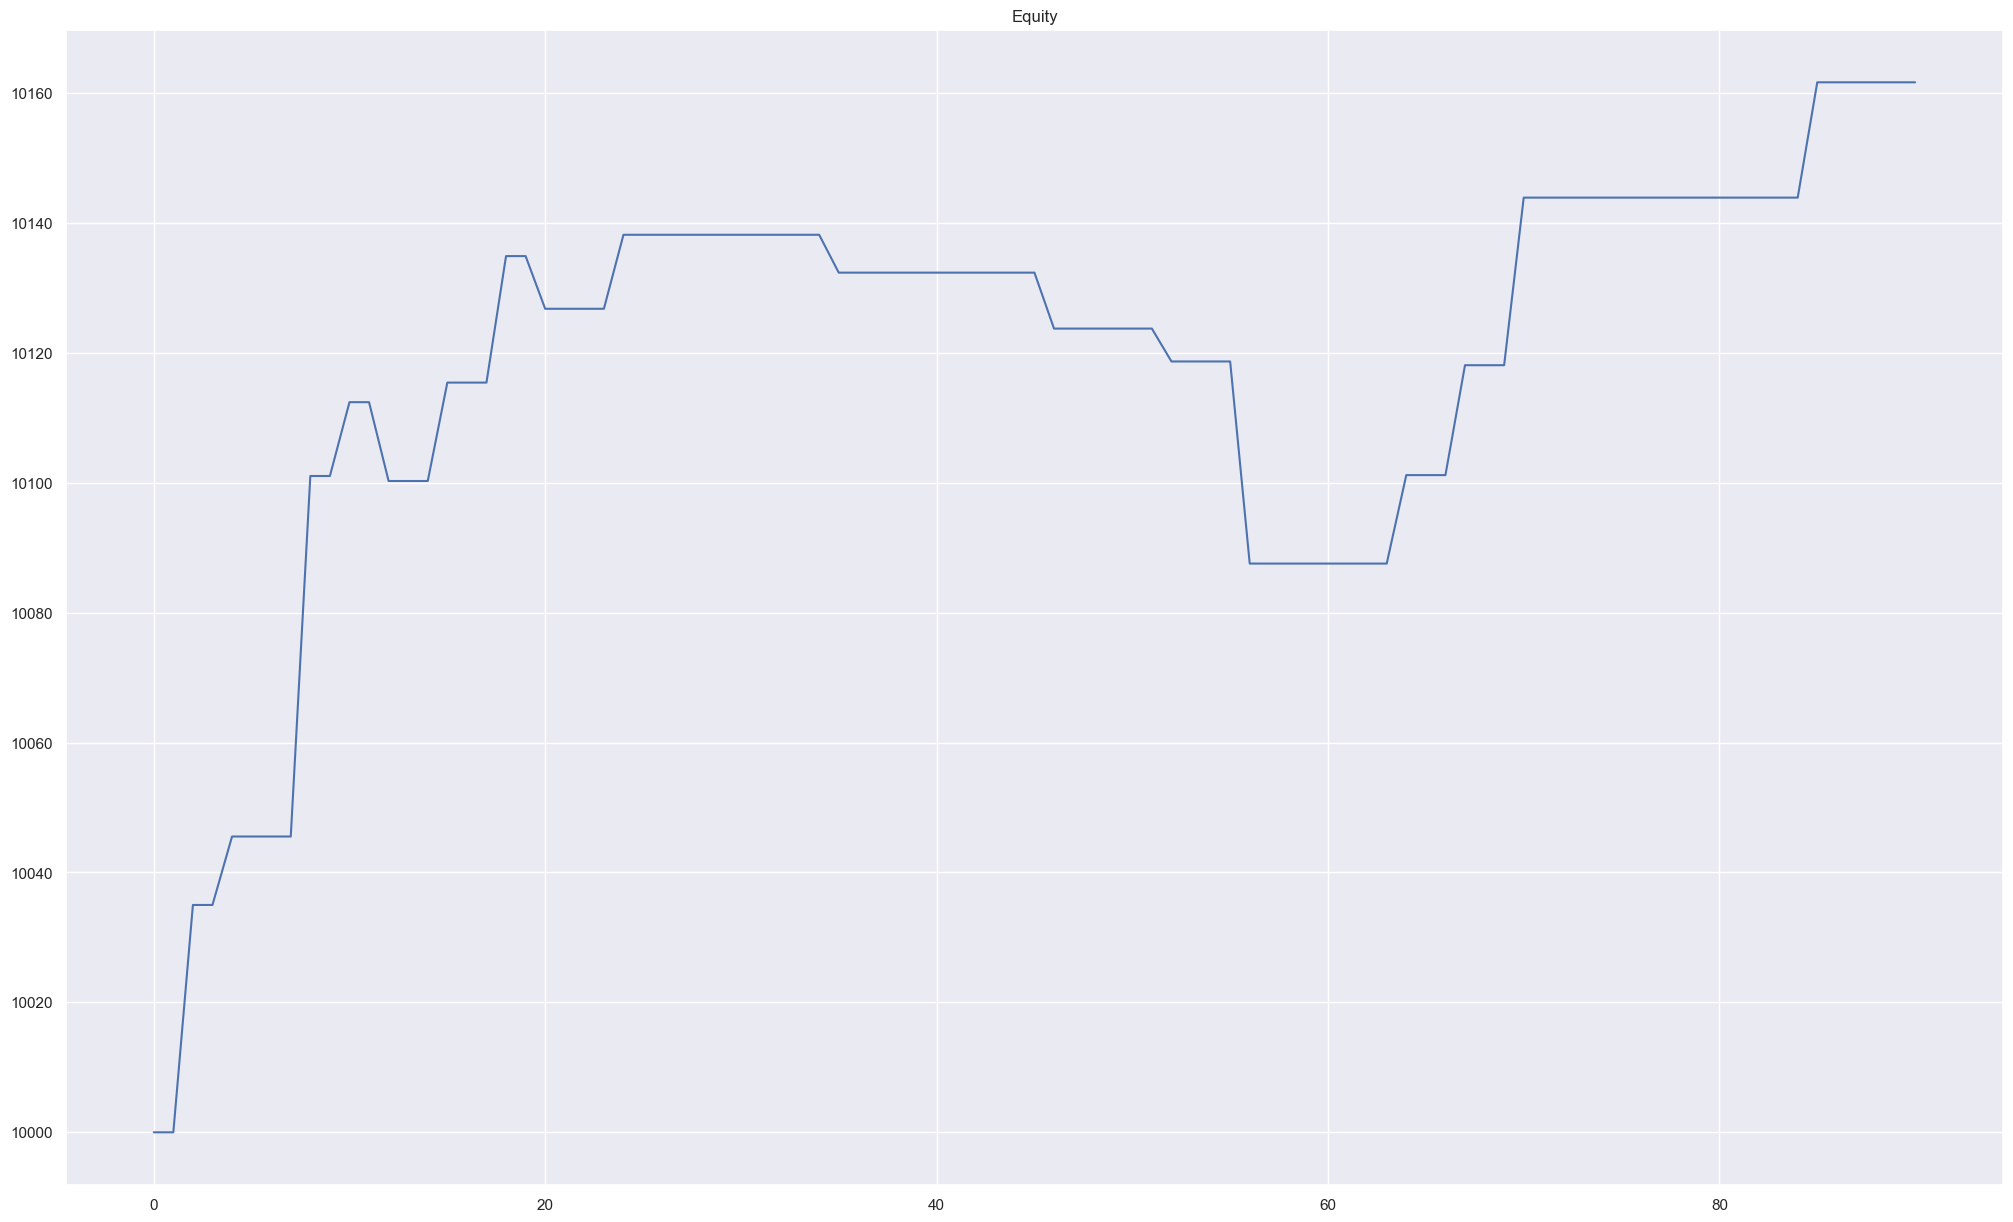

In [13]:
take_profit = 0.001 # % take profit
stop_loss = 0.0005 # % stop loss
cap = 10_000  # capital
laverage = 250 # laverage


def backtest(df, capital):
    initial_capital = capital
    plot_open_signal=[] # open signal
    plot_close_signal=[] # close signal
    equity_history=[]
    open_operation = False
    buffer_period=10
    df['open_signal'] = np.nan#pd.DataFrame(np.nan, index=range(len(df['close'])))#, columns=['A', 'B'])
    df['close_signal'] = np.nan
    
    for idx in range(len(df)):
        Date = df.index[idx]
        Open = df['Open'].iloc[idx]
        High = df['High'].iloc[idx]
        Low  = df['Low'].iloc[idx]
        Close  = df['Close'].iloc[idx]
        
        if int(idx) > buffer_period and int(idx) < len(df.values)-1:  # buffer
            
            if open_operation==False and Close < df['Close'].iloc[idx-2]:
                open_operation = True
                open_price = Close
                print('\nOPEN LONG position  | ',Date,' open operation price :',round(Close,8))
                plot_open_signal.append(idx)
                df['open_signal'].iloc[idx] = Close
                
            actual_price = Close
                                
            if open_operation==True: # LONG / BUY
                gain = (open_price - actual_price)*capital*laverage      
                real_TP = take_profit*capital
                real_SL = stop_loss*capital
                #print(gain,real_TP,real_SL)
                
                if (gain > real_TP or gain < -real_SL): # Close position 
                    capital += gain
                    open_operation = False
                    print('CLOSE LONG position | equity:', round(capital,2),' at ',Date, ' gain: ',round(gain,3),'$',' close operation price :',round(Close,10))
                    plot_close_signal.append(idx)
                    df['close_signal'].iloc[idx] = Close

            equity_history.append(capital)
    
    
    
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
    f.set_figheight(15)
    f.set_figwidth(20)

    print(plot_open_signal)
    print(plot_close_signal)
    
    # OPEN SIGNAL
    ax1.vlines(plot_open_signal,ymin=0,ymax=1,colors='green')
    ax1.set_title('open signal')

    ax1.set_ylim(0, 1)
    ax1.set_xlim(0,max(plot_open_signal)+5)
    x_axis1 = ax1.axes.get_xaxis()
    x_axis1.set_visible(False)
    y_axis1 = ax1.axes.get_yaxis()
    y_axis1.set_visible(False)
    
    # CLOSE SIGNAL
    ax2.vlines(plot_close_signal,ymin=0,ymax=1,colors='red')
    ax2.set_title('close signal')
    x_axis2 = ax2.axes.get_xaxis()    
    x_axis2.set_visible(True)
    y_axis2 = ax2.axes.get_yaxis()
    y_axis2.set_visible(False)
    ax2.set_ylim(0, 1)
    ax2.set_xlim(0,max(plot_open_signal)+5)
    
    
    # PRICES
    ax3.plot(df.index, df.Close,alpha=0.9)
    ax3.scatter(df.index,df['open_signal'], color='green', label='buy',marker='^',alpha=1 )
    ax3.scatter(df.index,df['close_signal'], color='red', label='sell' ,marker='v',alpha=1 )
    
    ax3.set_title('price chart')
    ax3.set_xticks(df.index[::5])
    ax3.set_xticklabels(df.index[::5], rotation=45)
    ax3.set_ylim(min(df.Close)*0.97, max(df.Close)*1.03)

    #plt.figure(figsize=(25,20))
    plt.show()
    
    return equity_history                    


def plot_equity(equity_history):
    f, ax1 = plt.subplots(1, 1, sharey=True)
    f.set_figheight(15)
    #f.set_figwidth(20)
    plt.plot(equity_history)
    plt.title('Equity')
    plt.show()
    
equity = backtest(df=df_price, capital=cap)
plot_equity(equity)